In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor

import lightgbm as lgb

from tqdm.notebook import tqdm

pd.set_option('display.max_row', 200)
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [3]:
def seed_everything(SEED=9):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)

SEED = 9
seed_everything(SEED)

## 전처리

In [4]:
df_kg = pd.read_csv("./food/Food_Supply_Quantity_kg_Data.csv")

a = df_kg.columns[-1]

df_kg = pd.read_csv("./food/Food_Supply_Quantity_kg_Data.csv").drop(a, axis=1)
df_prot = pd.read_csv("./food/Protein_Supply_Quantity_Data.csv").drop(a, axis=1)
df_kcal = pd.read_csv("./food/Food_Supply_kcal_Data.csv").drop(a, axis=1)
df_fat = pd.read_csv("./food/Fat_Supply_Quantity_Data.csv").drop(a, axis=1)
df_desc = pd.read_csv("./food/Supply_Food_Data_Descriptions.csv")

In [5]:
colnames = df_kg.columns

In [6]:
df_tmp1 = df_kg.join(df_prot.set_index('Country')[colnames[1:-7]], on='Country', lsuffix='_kg', rsuffix='_prot')
df_tmp2 = df_kcal[colnames[:-7]].join(df_fat.set_index('Country')[colnames[1:-7]], on='Country', lsuffix='_kcal', rsuffix='_fat')
df = df_tmp1.join(df_tmp2.set_index('Country'), on='Country')

### NULL 제거

In [7]:
df.isna().sum()

Country                          0
Alcoholic Beverages_kg           0
Animal fats_kg                   0
Animal Products_kg               0
Aquatic Products, Other_kg       0
Cereals - Excluding Beer_kg      0
Eggs_kg                          0
Fish, Seafood_kg                 0
Fruits - Excluding Wine_kg       0
Meat_kg                          0
Milk - Excluding Butter_kg       0
Miscellaneous_kg                 0
Offals_kg                        0
Oilcrops_kg                      0
Pulses_kg                        0
Spices_kg                        0
Starchy Roots_kg                 0
Stimulants_kg                    0
Sugar & Sweeteners_kg            0
Sugar Crops_kg                   0
Treenuts_kg                      0
Vegetable Oils_kg                0
Vegetables_kg                    0
Vegetal Products_kg              0
Obesity                          3
Undernourished                   7
Confirmed                        6
Deaths                           6
Recovered           

### Undernourished 데이터 클리닝

In [8]:
def tmp_func(x):
    if isinstance(x, float):
        return x
    else:
        if x == '<2.5':
            x = random.random() * 2.5
        else:
            x = float(x)
        return x       

In [10]:
df['Undernourished'] = df['Undernourished'].apply(tmp_func)

In [11]:
# 결측치 국가 제외
df_cleaned = df.dropna(axis=0)

In [12]:
df_cleaned.reset_index(drop=True, inplace=True)

In [13]:
df_cleaned_ = df_cleaned.copy()

In [14]:
df_cleaned__ = df_cleaned.copy()

In [15]:
df_cleaned__['Recovered_rate'] = df_cleaned['Recovered'] / df_cleaned['Confirmed']

### Correlation 값

<AxesSubplot:ylabel='Confirmed'>

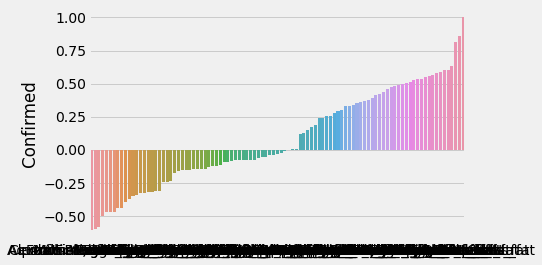

In [148]:
sns.barplot(x = df_cleaned.corr().columns, y=df_cleaned.corr()['Confirmed'].sort_values())

<AxesSubplot:ylabel='Recovered_rate'>

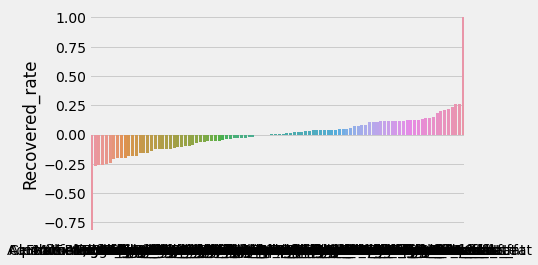

In [152]:
sns.barplot(x = df_cleaned__.corr().columns, y=df_cleaned__.corr()['Recovered_rate'].sort_values())

### 데이터 증강

In [16]:

coun = df_cleaned.loc[:,'Country']
head = df_cleaned.loc[:,'Alcoholic Beverages_kg':'Vegetal Products_kg']
tail = df_cleaned.loc[:,'Obesity':'Population']
body = df_cleaned.loc[:,'Alcoholic Beverages_prot':]
df_cleaned_ = pd.concat((coun, head, body, tail), axis=1)
while df_cleaned_.shape[0] < 100000:

    tmp_df = pd.concat((head, body), axis=1)
    normal_df = tmp_df * np.random.normal(size=tmp_df.shape) * 0.1 + tmp_df
    df_after = pd.concat((coun, normal_df, tail), axis=1)
    df_cleaned_ = pd.concat((df_cleaned_, df_after), axis=0)

In [17]:
df_cleaned_['Confirmed'] = df_cleaned_['Recovered'] / df_cleaned_['Confirmed'] # 회복

In [18]:
df_cleaned_.reset_index(drop=True, inplace=True)

In [19]:
min_max_scaler = MinMaxScaler()
fitted = min_max_scaler.fit(df_cleaned_.set_index('Country'))
arr_scale = min_max_scaler.transform(df_cleaned_.set_index('Country'))
df_scale = pd.DataFrame(arr_scale, columns=df_cleaned_.columns[1:])

In [20]:
df_scale

,Alcoholic Beverages_kg,Animal fats_kg,Animal Products_kg,"Aquatic Products, Other_kg",Cereals - Excluding Beer_kg,Eggs_kg,"Fish, Seafood_kg",Fruits - Excluding Wine_kg,Meat_kg,Milk - Excluding Butter_kg,Miscellaneous_kg,Offals_kg,Oilcrops_kg,Pulses_kg,Spices_kg,Starchy Roots_kg,Stimulants_kg,Sugar & Sweeteners_kg,Sugar Crops_kg,Treenuts_kg,Vegetable Oils_kg,Vegetables_kg,Vegetal Products_kg,Alcoholic Beverages_prot,Animal fats_prot,Animal Products_prot,"Aquatic Products, Other_prot",Cereals - Excluding Beer_prot,Eggs_prot,"Fish, Seafood_prot",Fruits - Excluding Wine_prot,Meat_prot,Milk - Excluding Butter_prot,Miscellaneous_prot,Offals_prot,Oilcrops_prot,Pulses_prot,Spices_prot,Starchy Roots_prot,Stimulants_prot,Sugar & Sweeteners_prot,Sugar Crops_prot,Treenuts_prot,Vegetable Oils_prot,Vegetables_prot,Vegetal Products_prot,Alcoholic Beverages_kcal,Animal fats_kcal,Animal Products_kcal,"Aquatic Products, Other_kcal",Cereals - Excluding Beer_kcal,Eggs_kcal,"Fish, Seafood_kcal",Fruits - Excluding Wine_kcal,Meat_kcal,Milk - Excluding Butter_kcal,Miscellaneous_kcal,Offals_kcal,Oilcrops_kcal,Pulses_kcal,Spices_kcal,Starchy Roots_kcal,Stimulants_kcal,Sugar & Sweeteners_kcal,Sugar Crops_kcal,Treenuts_kcal,Vegetable Oils_kcal,Vegetables_kcal,Vegetal Products_kcal,Alcoholic Beverages_fat,Animal fats_fat,Animal Products_fat,"Aquatic Products, Other_fat",Cereals - Excluding Beer_fat,Eggs_fat,"Fish, Seafood_fat",Fruits - Excluding Wine_fat,Meat_fat,Milk - Excluding Butter_fat,Miscellaneous_fat,Offals_fat,Oilcrops_fat,Pulses_fat,Spices_fat,Starchy Roots_fat,Stimulants_fat,Sugar & Sweeteners_fat,Sugar Crops_fat,Treenuts_fat,Vegetable Oils_fat,Vegetables_fat,Vegetal Products_fat,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population
0,0.000069,0.107200,0.224358,0.000000,0.622612,0.089916,0.000892,0.199896,0.092316,0.274732,0.015760,0.127554,0.004002,0.065034,0.064525,0.011129,0.190365,0.093899,0.000000,0.078574,0.164977,0.278447,0.484719,0.000000,0.020576,0.149222,0.000000,0.720465,0.079911,0.000828,0.090217,0.090398,0.257944,0.033064,0.133427,0.017891,0.051857,0.065810,0.006795,0.162412,0.000000,0.000000,0.054451,0.000000,0.175250,0.626784,0.000000,0.082632,0.127700,0.0,0.717689,0.072034,0.000000,0.119733,0.073796,0.171599,0.016009,0.119160,0.011990,0.048801,0.064589,0.004966,0.026604,0.143542,0.000000,0.064835,0.126074,0.157787,0.557425,0.000000,0.316418,0.410128,0.0,0.290729,0.155161,0.001002,0.030235,0.163111,0.354965,0.027344,0.326504,0.028017,0.054763,0.078078,0.014037,0.022546,0.0,0.00000,0.116564,0.309629,0.219200,0.364290,0.055300,0.499865,0.868010,0.033360,0.013648,0.001568,0.027709
1,0.082123,0.073513,0.478705,0.000000,0.095120,0.263198,0.016426,0.258450,0.159159,0.572221,0.024311,0.144111,0.058844,0.052415,0.000899,0.036535,0.064059,0.109764,0.000000,0.154597,0.092649,0.504550,0.306322,0.106287,0.052813,0.545706,0.000000,0.200367,0.377291,0.025396,0.206075,0.255818,0.784470,0.038933,0.249984,0.033202,0.060484,0.000000,0.054402,0.075682,0.007028,0.000000,0.105094,0.053590,0.535504,0.260218,0.140309,0.103614,0.517183,0.0,0.230662,0.415377,0.024777,0.331509,0.272877,0.713402,0.037654,0.252227,0.078515,0.078922,0.000000,0.041160,0.088716,0.238615,0.000000,0.205854,0.164850,0.613510,0.323894,0.000000,0.170979,0.644476,0.0,0.080821,0.384906,0.011124,0.046703,0.239954,0.767088,0.028519,0.308616,0.087355,0.032075,0.000000,0.014733,0.121245,0.0,0.00000,0.142443,0.132321,0.406524,0.164167,0.465438,0.103785,0.604130,0.274778,0.198303,0.140117,0.001972
2,0.013316,0.014725,0.229788,0.000000,0.314120,0.238111,0.018962,0.241902,0.085313,0.276051,0.036174,0.053948,0.021655,0.105336,0.062614,0.100074,0.136546,0.134896,0.000000,0.117555,0.337293,0.498824,0.480908,0.018658,0.004011,0.239200,0.000000,0.495295,0.267849,0.025728,0.187141,0.104112,0.379812,0.100123,0.074044,0.016041,0.106005,0.070240,0.094069,0.135061,0.000000,0.000000,0.107763,0.171616,0.515190,0.543695,0.013785,0.016648,0.170904,0.0,0.435660,0.211663,0.020128,0.268768,0.0

In [21]:
front = pd.concat([df_cleaned_['Country'], df_scale.loc[:,:'Undernourished']], axis=1)
back = df_scale['Population']
df_train = pd.concat([front, back], axis=1)

In [22]:
df_train

,Country,Alcoholic Beverages_kg,Animal fats_kg,Animal Products_kg,"Aquatic Products, Other_kg",Cereals - Excluding Beer_kg,Eggs_kg,"Fish, Seafood_kg",Fruits - Excluding Wine_kg,Meat_kg,Milk - Excluding Butter_kg,Miscellaneous_kg,Offals_kg,Oilcrops_kg,Pulses_kg,Spices_kg,Starchy Roots_kg,Stimulants_kg,Sugar & Sweeteners_kg,Sugar Crops_kg,Treenuts_kg,Vegetable Oils_kg,Vegetables_kg,Vegetal Products_kg,Alcoholic Beverages_prot,Animal fats_prot,Animal Products_prot,"Aquatic Products, Other_prot",Cereals - Excluding Beer_prot,Eggs_prot,"Fish, Seafood_prot",Fruits - Excluding Wine_prot,Meat_prot,Milk - Excluding Butter_prot,Miscellaneous_prot,Offals_prot,Oilcrops_prot,Pulses_prot,Spices_prot,Starchy Roots_prot,Stimulants_prot,Sugar & Sweeteners_prot,Sugar Crops_prot,Treenuts_prot,Vegetable Oils_prot,Vegetables_prot,Vegetal Products_prot,Alcoholic Beverages_kcal,Animal fats_kcal,Animal Products_kcal,"Aquatic Products, Other_kcal",Cereals - Excluding Beer_kcal,Eggs_kcal,"Fish, Seafood_kcal",Fruits - Excluding Wine_kcal,Meat_kcal,Milk - Excluding Butter_kcal,Miscellaneous_kcal,Offals_kcal,Oilcrops_kcal,Pulses_kcal,Spices_kcal,Starchy Roots_kcal,Stimulants_kcal,Sugar & Sweeteners_kcal,Sugar Crops_kcal,Treenuts_kcal,Vegetable Oils_kcal,Vegetables_kcal,Vegetal Products_kcal,Alcoholic Beverages_fat,Animal fats_fat,Animal Products_fat,"Aquatic Products, Other_fat",Cereals - Excluding Beer_fat,Eggs_fat,"Fish, Seafood_fat",Fruits - Excluding Wine_fat,Meat_fat,Milk - Excluding Butter_fat,Miscellaneous_fat,Offals_fat,Oilcrops_fat,Pulses_fat,Spices_fat,Starchy Roots_fat,Stimulants_fat,Sugar & Sweeteners_fat,Sugar Crops_fat,Treenuts_fat,Vegetable Oils_fat,Vegetables_fat,Vegetal Products_fat,Obesity,Undernourished,Population
0,Afghanistan,0.000069,0.107200,0.224358,0.000000,0.622612,0.089916,0.000892,0.199896,0.092316,0.274732,0.015760,0.127554,0.004002,0.065034,0.064525,0.011129,0.190365,0.093899,0.000000,0.078574,0.164977,0.278447,0.484719,0.000000,0.020576,0.149222,0.000000,0.720465,0.079911,0.000828,0.090217,0.090398,0.257944,0.033064,0.133427,0.017891,0.051857,0.065810,0.006795,0.162412,0.000000,0.000000,0.054451,0.000000,0.175250,0.626784,0.000000,0.082632,0.127700,0.0,0.717689,0.072034,0.000000,0.119733,0.073796,0.171599,0.016009,0.119160,0.011990,0.048801,0.064589,0.004966,0.026604,0.143542,0.000000,0.064835,0.126074,0.157787,0.557425,0.000000,0.316418,0.410128,0.0,0.290729,0.155161,0.001002,0.030235,0.163111,0.354965,0.027344,0.326504,0.028017,0.054763,0.078078,0.014037,0.022546,0.0,0.00000,0.116564,0.309629,0.219200,0.364290,0.055300,0.499865,0.027709
1,Albania,0.082123,0.073513,0.478705,0.000000,0.095120,0.263198,0.016426,0.258450,0.159159,0.572221,0.024311,0.144111,0.058844,0.052415,0.000899,0.036535,0.064059,0.109764,0.000000,0.154597,0.092649,0.504550,0.306322,0.106287,0.052813,0.545706,0.000000,0.200367,0.377291,0.025396,0.206075,0.255818,0.784470,0.038933,0.249984,0.033202,0.060484,0.000000,0.054402,0.075682,0.007028,0.000000,0.105094,0.053590,0.535504,0.260218,0.140309,0.103614,0.517183,0.0,0.230662,0.415377,0.024777,0.331509,0.272877,0.713402,0.037654,0.252227,0.078515,0.078922,0.000000,0.041160,0.088716,0.238615,0.000000,0.205854,0.164850,0.613510,0.323894,0.000000,0.170979,0.644476,0.0,0.080821,0.384906,0.011124,0.046703,0.239954,0.767088,0.028519,0.308616,0.087355,0.032075,0.000000,0.014733,0.121245,0.0,0.00000,0.142443,0.132321,0.406524,0.164167,0.465438,0.103785,0.001972
2,Algeria,0.013316,0.014725,0.229788,0.000000,0.314120,0.238111,0.018962,0.241902,0.085313,0.276051,0.036174,0.053948,0.021655,0.105336,0.062614,0.100074,0.136546,0.134896,0.000000,0.117555,0.337293,0.498824,0.480908,0.018658,0.004011,0.239200,0.000000,0.495295,0.267849,0.025728,0.187141,0.104112,0.379812,0.100123,0.074044,0.016041,0.106005,0.070240,0.094069,0.135061,0.000000,0.000000,0.107763,0.171616,0.515190,0.543695,0.013785,0.016648,0.170904,0.0,0.435660,0.211663,0.020128,0.268768,0.077803,0.282644,0.066919,0.056865,0.018813,0.106322,0.077107,0.066618,0

In [23]:
df_label = df_scale.loc[:,'Confirmed'] # 확진비율

In [24]:
df_train.to_csv('train.csv', index=False)

In [27]:
df_label

0         0.868010
1         0.604130
2         0.684256
3         0.920895
4         0.896478
            ...   
100095    0.937721
100096    0.739547
100097    0.671368
100098    0.869487
100099    0.823006
Name: Confirmed, Length: 100100, dtype: float64

## 학습

In [126]:
df_train = df_train.iloc[:,1:]

In [100]:
dict_sample = {key: value for (key, value) in zip(df_train.Country.unique(), range(len(df_train.Country.unique())))}

In [101]:
dict_sample

{'Afghanistan': 0,
 'Albania': 1,
 'Algeria': 2,
 'Angola': 3,
 'Argentina': 4,
 'Armenia': 5,
 'Australia': 6,
 'Austria': 7,
 'Azerbaijan': 8,
 'Bangladesh': 9,
 'Barbados': 10,
 'Belarus': 11,
 'Belgium': 12,
 'Belize': 13,
 'Benin': 14,
 'Bolivia': 15,
 'Bosnia and Herzegovina': 16,
 'Botswana': 17,
 'Brazil': 18,
 'Bulgaria': 19,
 'Burkina Faso': 20,
 'Cabo Verde': 21,
 'Cambodia': 22,
 'Cameroon': 23,
 'Central African Republic': 24,
 'Chad': 25,
 'China': 26,
 'Colombia': 27,
 'Congo': 28,
 'Costa Rica': 29,
 "Cote d'Ivoire": 30,
 'Croatia': 31,
 'Cuba': 32,
 'Cyprus': 33,
 'Czechia': 34,
 'Denmark': 35,
 'Djibouti': 36,
 'Dominica': 37,
 'Dominican Republic': 38,
 'Ecuador': 39,
 'Egypt': 40,
 'El Salvador': 41,
 'Estonia': 42,
 'Eswatini': 43,
 'Ethiopia': 44,
 'Fiji': 45,
 'Finland': 46,
 'France': 47,
 'Gabon': 48,
 'Gambia': 49,
 'Georgia': 50,
 'Germany': 51,
 'Ghana': 52,
 'Greece': 53,
 'Guatemala': 54,
 'Guinea': 55,
 'Guinea-Bissau': 56,
 'Guyana': 57,
 'Haiti': 58,
 '

In [104]:
df_train.Country = df_train.Country.replace(dict_sample)

In [127]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [128]:
model_params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': 'mse',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'n_estimators': 100,
    'seed':SEED,
    'verbose': 1,
    'n_jobs': -1,
    'force_col_wise':True
}

for train_index, test_index in kf.split(df_train):
    x_train, x_test = df_train.iloc[train_index].to_numpy(), df_train.iloc[test_index].to_numpy()
    y_train, y_test = df_label.iloc[train_index].to_numpy(), df_label.iloc[test_index].to_numpy()
    
    print(x_train.shape, x_test.shape)
    
    fi = pd.DataFrame()
    fi['feature'] = df_train.columns[:]
    
    dtrain = lgb.Dataset(x_train, label=y_train, categorical_feature=[0])
    
    clf = lgb.train(
        model_params,
        dtrain,
#         categorical_feature='auto',
        verbose_eval=200
    )
    
    test_preds = clf.predict(x_test)
    
    fi['importance'] = clf.feature_importance()
    break

(80080, 95) (20020, 95)
[LightGBM] [Info] Total Bins 23606
[LightGBM] [Info] Number of data points in the train set: 80080, number of used features: 94
[LightGBM] [Info] Start training from score 0.781883


In [129]:
def visualize_importance(df):
    df = df.sort_values('importance', ascending = False).reset_index(drop=True)

    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')

    df.loc[:20, :].plot.barh(y='importance_normalized',
                            x='feature', color='b',
                            edgecolor='k', figsize=(20, 15),
                            legend=False)

    plt.xlabel('Normalized Importance', size=15)


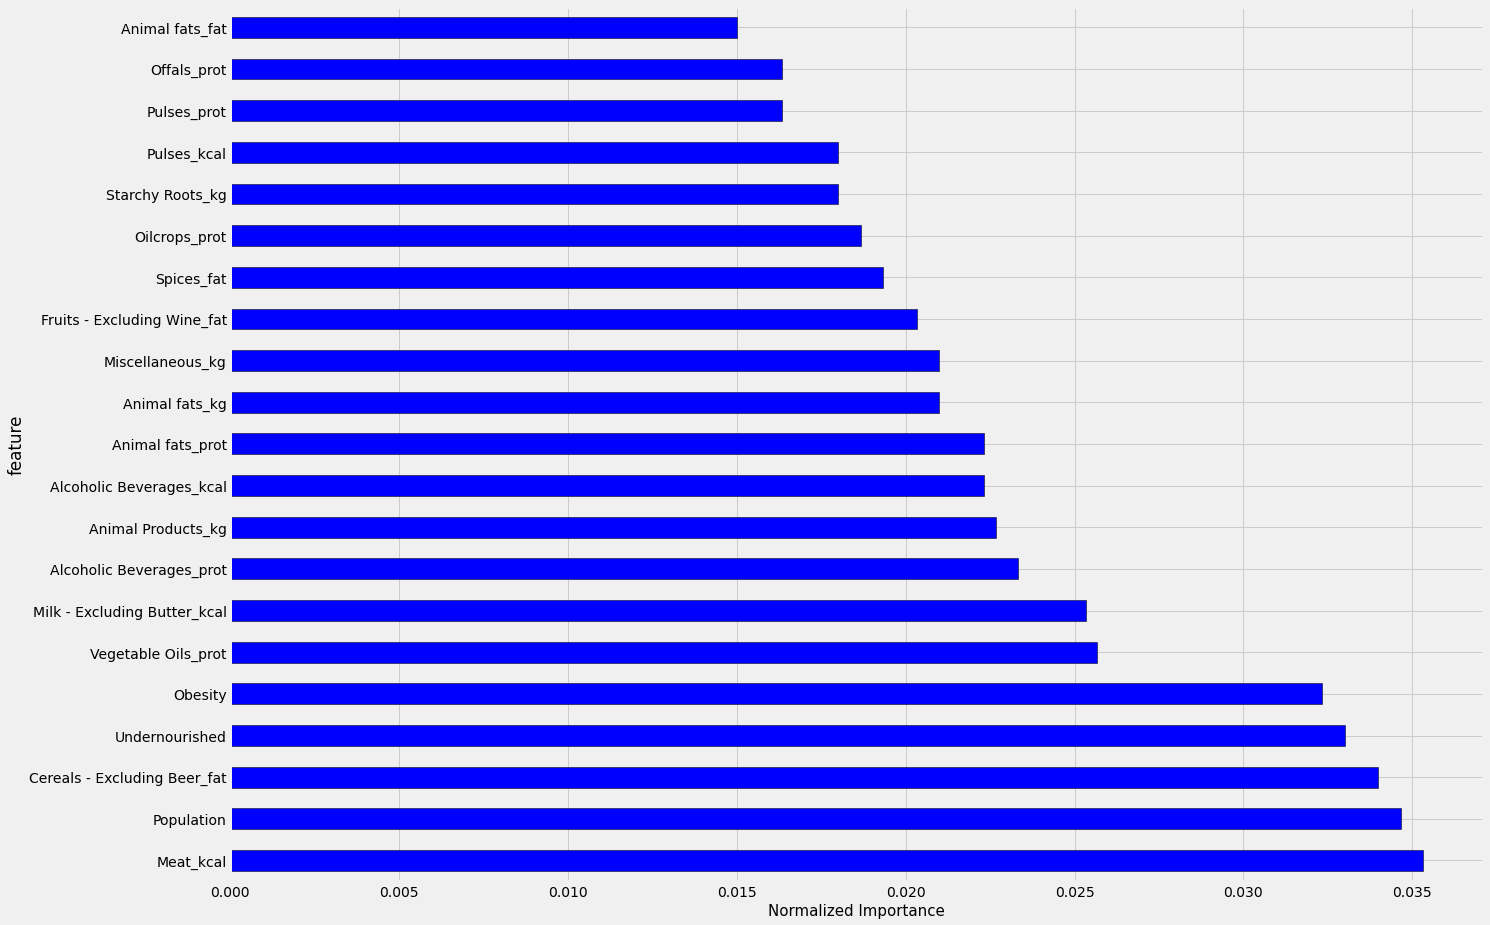

In [130]:
visualize_importance(fi) # regression 10% correlation값 불완전하지만 둘 사이 관계는 확실했다.

In [67]:
test_preds.shape

(31,)

In [62]:
y_test.shape

(31,)

In [64]:
mean_squared_error(y_test, test_preds)

0.013993439949714508